In [336]:
import numpy as np
import pandas as pd
import re
import json

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

from keras.models import Sequential
from keras.layers import LSTM, GRU, Activation, Dense, Dropout, Input, Embedding, MaxPooling1D
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping

import seaborn as sn

In [138]:
data = pd.read_csv("dataset/tweets.csv")
data.head()

,user_id,tweet,label
0,66378098,[HARI PEREMPUAN INTERNASIONAL]\n\nHari Perempu...,0
1,66378098,Selamat Hari kartini @HimkaITS @hmtc_its @HIMA...,0
2,66378098,"Malam refleksi kebangsaan, 10 nopember 2015 ol...",0
3,66378098,Selamat datang semester baru semoga di beri ke...,0
4,66378098,Fisika dipenuhi warna hijau siap untuk outbond...,0


In [139]:
data['label'].value_counts()

0    713
1    185
Name: label, dtype: int64

In [140]:
def clean_text(text):
    text = text.lower()
    
    text = re.sub(r'@[A-Za-z0-9]+', ' ', text)
    text = re.sub(r'#[A-Za-z0-9]+', ' ', text)
    text = re.sub(r'\w+:\/\/\S+', ' ', text)
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    
    text = re.sub(r' +', ' ', text)
    
    return ' '.join(text.split())

In [141]:
def replace_slang(text, acronym):
    res = []
    
    for w in text.split(' '):
        if w in acronym:
            res.append(acronym[w])
        else:
            res.append(w)
    
    return ' '.join(res)

In [142]:
def stemming(text, stemmer):
    stem_text = stemmer.stem(text)
    return stem_text

In [143]:
with open("extra/akronim.json", "r") as f:    
    acronym_map = json.load(f)

In [144]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [149]:
data['tweet'] = data['tweet'].apply(lambda x: clean_text(x))
data['tweet'] = data['tweet'].apply(lambda x: replace_slang(x, acronym_map))
data['tweet'] = data['tweet'].apply(lambda x: stemming(x, stemmer))

In [152]:
X_train, X_test, Y_train, Y_test = train_test_split(data['tweet'], data['label'], test_size=0.25)

In [157]:
Y_test.value_counts()

0    188
1     37
Name: label, dtype: int64

In [158]:
Y_train.value_counts()

0    525
1    148
Name: label, dtype: int64

In [249]:
max_words = 5000
max_len = 50

In [250]:
tok = Tokenizer(num_words=max_words, lower=True)
tok.fit_on_texts(X_train)

sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences, maxlen=max_len)

In [251]:
len(tok.word_index)

3149

In [252]:
tok.word_index

{'its': 1,
 'yang': 2,
 'di': 3,
 'dan': 4,
 'hari': 5,
 'ini': 6,
 'selamat': 7,
 'untuk': 8,
 'pada': 9,
 '2018': 10,
 '2019': 11,
 'dengan': 12,
 'langsung': 13,
 'dari': 14,
 'yuk': 15,
 '1': 16,
 'akan': 17,
 '00': 18,
 'sedang': 19,
 'the': 20,
 'kalian': 21,
 'ke': 22,
 'jadi': 23,
 '2': 24,
 'surabaya': 25,
 'ada': 26,
 'teknik': 27,
 'ikut': 28,
 '2017': 29,
 'daftar': 30,
 'kita': 31,
 'mahasiswa': 32,
 'halo': 33,
 'to': 34,
 '3': 35,
 'dalam': 36,
 'tahun': 37,
 'indonesia': 38,
 'tanggal': 39,
 'teman': 40,
 'bisa': 41,
 'amp': 42,
 'jangan': 43,
 'schematics': 44,
 'sudah': 45,
 'baru': 46,
 'datang': 47,
 'nih': 48,
 'telah': 49,
 'bagi': 50,
 'and': 51,
 'departemen': 52,
 'saat': 53,
 'of': 54,
 'you': 55,
 'mesin': 56,
 'dapat': 57,
 'live': 58,
 '2016': 59,
 '30': 60,
 'moga': 61,
 'sama': 62,
 'juang': 63,
 'buat': 64,
 'wib': 65,
 'lagi': 66,
 'is': 67,
 'ya': 68,
 'tidak': 69,
 'oleh': 70,
 'acara': 71,
 'lanjut': 72,
 'lebih': 73,
 'november': 74,
 'diri': 75,
 '

In [253]:
sequences_matrix.shape

(673, 50)

In [329]:
def lstm_model():
    model = Sequential()
    
    model.add(Embedding(max_words, 32, input_length=max_len))
    #model.add(LSTM(64))
    model.add(GRU(32))
    
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    print(model.summary())

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

    return model

In [330]:
model = lstm_model()
model.fit(sequences_matrix, Y_train, 
          batch_size=64, epochs=30, verbose=1, 
          validation_split=0.2, 
          callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_29 (Embedding)     (None, 50, 32)            160000    
_________________________________________________________________
gru_5 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_56 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_28 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_57 (Dense)             (None, 1)                 33        
Total params: 167,329
Trainable params: 167,329
Non-trainable params: 0
_________________________________________________________________
None
Train on 538 samples, validate on 135 samples
Epoch 1/30
538/538 [==============================] - 7s 13ms/step - loss: 0.6858 - a

In [331]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences, maxlen=max_len)

In [332]:
ans = model.evaluate(test_sequences_matrix, Y_test)

225/225 [==============================] - 0s 193us/step


In [333]:
print('Test set\nLoss: {:0.3f}\nAccuracy: {:0.3f}'.format(ans[0], ans[1]))

Test set
Loss: 0.314
Accuracy: 0.938


In [356]:
y_pred = model.predict_classes(test_sequences_matrix)

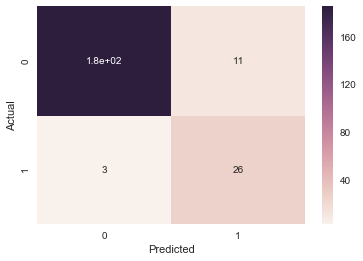

In [361]:
cfm = {'y_pred': y_pred.reshape(225), 'y_true': Y_test.values}
cfm_df = pd.DataFrame(cfm)
confusion_matrix = pd.crosstab(cfm_df['y_pred'], cfm_df['y_true'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True)

In [360]:
y_pred.reshape(225)

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0], dtype=int32)